In [10]:
#@title
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/bert

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/bert


In [11]:
#@title
%%capture
!pip install shap
!pip install interpret
!pip install nltk
!pip install wordcloud

In [12]:
#@title
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import interpret.glassbox
import shap
import random
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')

from preprocess_data import read_dublin_data, read_sentiment_data, preprocess_data
from evaluate import evaluate_model


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Parameters

In [13]:
#@title
MAX_FEATURES = 5000
N_TWEET_PRINT = 10

# Read Data

In [14]:
#@title
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-train.csv"
df_train = read_sentiment_data(filename)

In [15]:
#@title
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-test.csv"
df_test = read_sentiment_data(filename)

In [16]:
#@title
%%capture
filename = "/content/gdrive/MyDrive/bert/citypulse.dublin_city_council.test.csv"
df_dublin = read_dublin_data(filename)

In [17]:
#@title
df_train['split'] = "train"
df_test['split'] = "test"
df_all = pd.concat([df_train, df_test])

# Target distribution in each dataset
* Positive and negative sentiment are equally split in all datasets

In [18]:
#@title
df_train['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [19]:
#@title
df_test['sentiment'].value_counts()

1    182
0    177
Name: sentiment, dtype: int64

In [20]:
#@title
df_dublin['sentiment'].value_counts()

1    1000
0    1000
Name: sentiment, dtype: int64

In [21]:
#@title
df_dublin = preprocess_data(df_dublin, stopwords)
df_train = preprocess_data(df_train, stopwords)
df_test = preprocess_data(df_test, stopwords)
df_all = preprocess_data(df_all, stopwords)

In [22]:
#@title
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                                  sublinear_tf=True, strip_accents='unicode',
                                  stop_words='english', ngram_range=(1, 2),
                                  max_features=MAX_FEATURES)
word_vectorizer.fit(df_all['text_clean'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

# Split train/test features and target

In [23]:
#@title
train_text = df_all.loc[df_all['split']=="train", "text_clean"]
test_text = df_all.loc[df_all['split']=="test", "text_clean"]
all_text = df_all["text_clean"]
y_train = df_all.loc[df_all['split']=="train", "sentiment"]
y_test = df_all.loc[df_all['split']=="train", "sentiment"]
y_all_text = df_all["sentiment"]

In [24]:
#@title
x_dublin = df_dublin["text_clean"]
y_dublin = df_dublin["sentiment"]

In [25]:
#@title
train_features = word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)
all_features = word_vectorizer.transform(all_text)
dublin_features = word_vectorizer.transform(x_dublin)

# Fit Logistic Regression model

In [26]:
#@title
lr = LogisticRegression(penalty='l2',C=1,
                        max_iter = 1000, solver='lbfgs')
lr.fit(train_features,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Make predictions

In [27]:
#@title
df_dublin['sentiment_pred'] = lr.predict(dublin_features)
df_all['sentiment_pred'] = lr.predict(all_features)

### Metrics Train

In [28]:
#@title
y_hat = df_all.loc[df_all['split']=="train", "sentiment"]
y_pred = df_all.loc[df_all['split']=="train", "sentiment_pred"]
evaluate_model(y_hat, y_pred)

[[593479 206521]
 [161822 638178]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76    800000
           1       0.76      0.80      0.78    800000

    accuracy                           0.77   1600000
   macro avg       0.77      0.77      0.77   1600000
weighted avg       0.77      0.77      0.77   1600000

Accuracy Score: 0.770


### Metrics Test

In [29]:
#@title
y_hat = df_all.loc[(df_all['split']=="test") & (df_all['sentiment']!=-1), "sentiment"]
y_pred = df_all.loc[(df_all['split']=="test") & (df_all['sentiment']!=-1), "sentiment_pred"]
evaluate_model(y_hat, y_pred)

[[137  40]
 [ 28 154]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       177
           1       0.79      0.85      0.82       182

    accuracy                           0.81       359
   macro avg       0.81      0.81      0.81       359
weighted avg       0.81      0.81      0.81       359

Accuracy Score: 0.811


### Metrics Dublin dataset

In [30]:
#@title
y_hat = df_dublin.loc[(df_dublin['sentiment']!=-1), "sentiment"]
y_pred = df_dublin.loc[(df_dublin['sentiment']!=-1), "sentiment_pred"]
evaluate_model(y_hat, y_pred)

[[757 243]
 [451 549]]
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1000
           1       0.69      0.55      0.61      1000

    accuracy                           0.65      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.65      0.65      2000

Accuracy Score: 0.653


<a id='Metrics-Category'></a>
### Metrics by category

In [31]:
#@title
for category in df_dublin['category'].unique():
    print(category)
    y_hat = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment"]
    y_pred = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment_pred"]
    evaluate_model(y_hat, y_pred)

Public Spaces
[[748 239]
 [447 545]]
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       987
           1       0.70      0.55      0.61       992

    accuracy                           0.65      1979
   macro avg       0.66      0.65      0.65      1979
weighted avg       0.66      0.65      0.65      1979

Accuracy Score: 0.653
Community and Culture
[[664 194]
 [361 353]]
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       858
           1       0.65      0.49      0.56       714

    accuracy                           0.65      1572
   macro avg       0.65      0.63      0.63      1572
weighted avg       0.65      0.65      0.64      1572

Accuracy Score: 0.647
Mobility
[[558 183]
 [355 460]]
              precision    recall  f1-score   support

           0       0.61      0.75      0.67       741
           1       0.72      0.56      0.63       815

    accuracy            

In [32]:
#@title
df_dublin['sentiment_pred_class'] = df_dublin['sentiment_pred'].astype(int)

### Words with Higher TFIDF values in test dataset

In [33]:
#@title
feature_array = np.array(word_vectorizer.get_feature_names())
tfidf_sorting = np.argsort(test_features.toarray()).flatten()[::-1]

n = 50
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['incredibly', 'iran', 'reading', 'tweets', 'coming', 'thing',
       'sad', 'glorious', 'glad like', 'given', 'gives', 'giving', 'glad',
       'glad got', 'glad hear', 'gmail', 'gloomy', 'gm', 'girly',
       'glasgow', 'glass', 'glasses', 'glad u', 'ø ø', 'god', 'girls',
       'getting better', 'getting new', 'getting old', 'getting ready',
       'getting sick', 'gf', 'gfalcone601', 'ghost', 'giant', 'gift',
       'gig', 'ginger', 'girl', 'girlfriend', 'girlie', 'goal', 'goes',
       'god bless', 'gonna make', 'gold', 'golden', 'golf', 'gona',
       'gone'], dtype='<U19')

### Words with Higher TFIDF values in dublin dataset

In [34]:
#@title
tfidf_sorting = np.argsort(dublin_features.toarray()).flatten()[::-1]
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['built', 'dublin', 'yes', 'ahead', 'line', 'past', 'town',
       'fucking', 'mad', 'years', 'thing', 't', 's', 'gonna try',
       'glad like', 'giving', 'glad', 'glad got', 'glad hear', 'glad u',
       'given', 'glasgow', 'good bye', 'glass', 'glasses', 'gloomy',
       'glorious', 'gives', 'girly', 'gmail', 'girls', 'getting new',
       'getting old', 'getting ready', 'getting sick', 'gf',
       'gfalcone601', 'ghost', 'giant', 'gift', 'good day', 'gig',
       'ginger', 'girl', 'girlfriend', 'girlie', 'gm', 'goal',
       'gonna watch', 'going shopping'], dtype='<U19')

# Wordcloud most frequent words Train vs Test vs Dublin dataset

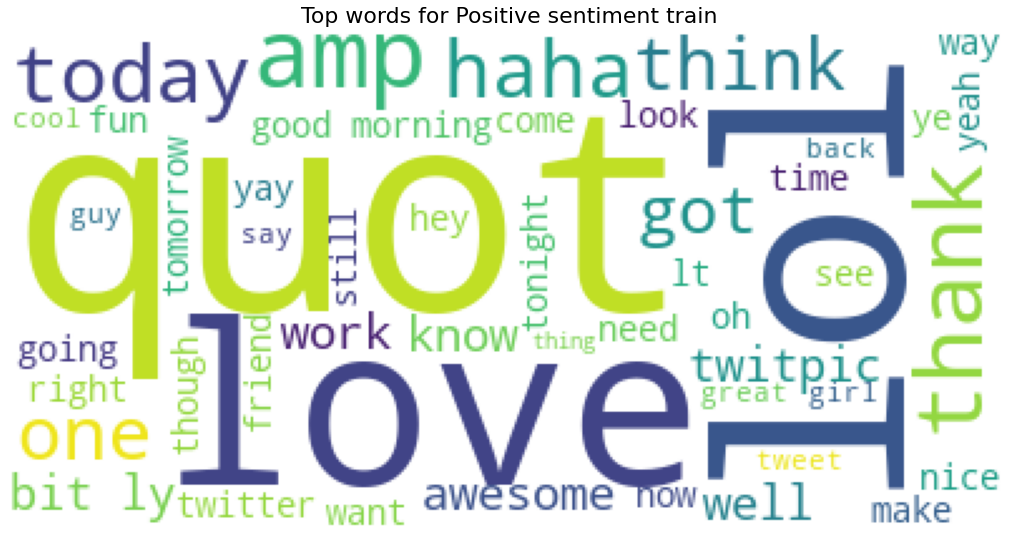

In [35]:
#@title
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_train.loc[df_train['sentiment'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive sentiment train', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

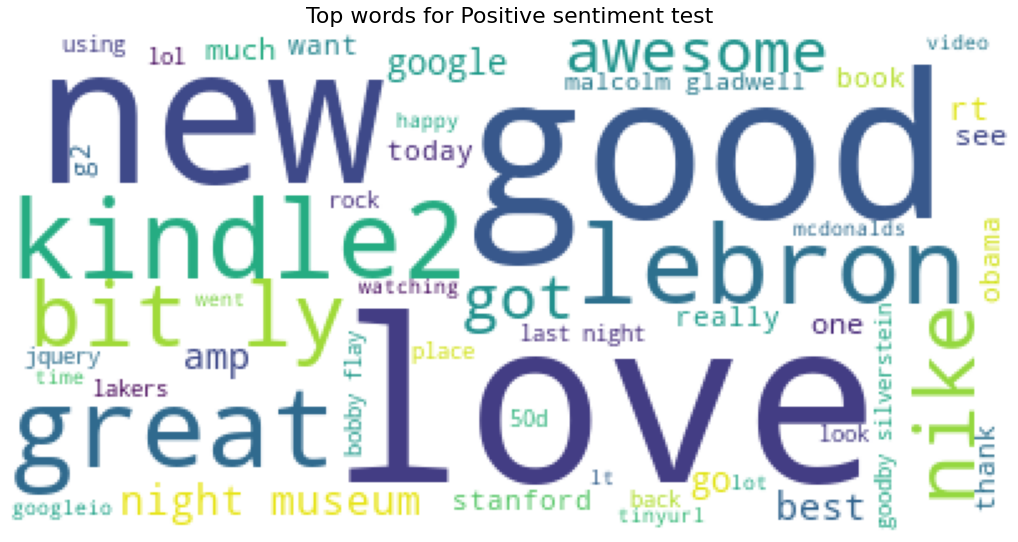

In [36]:
#@title
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_test.loc[df_test['sentiment'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive sentiment test', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

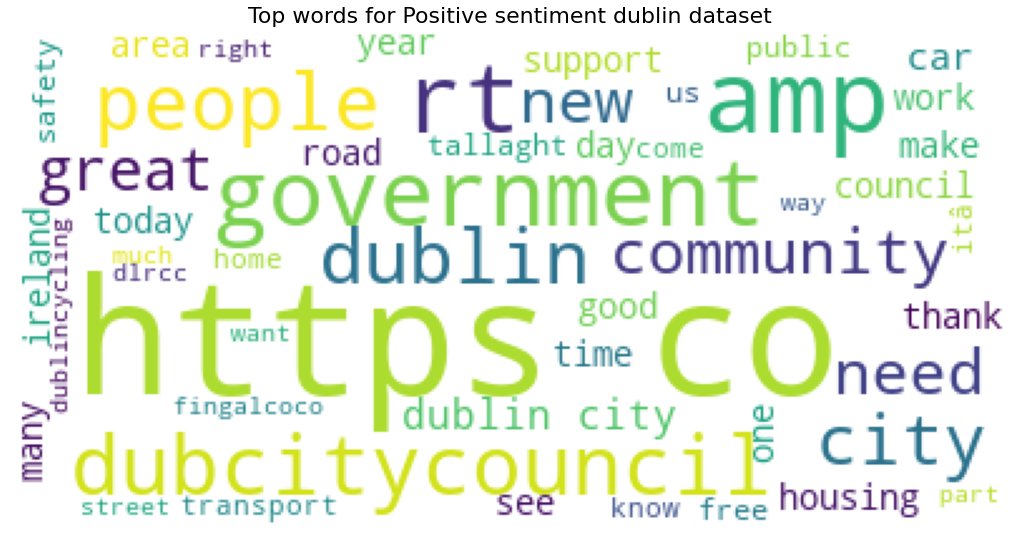

In [37]:
#@title
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_dublin.loc[df_dublin['sentiment'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive sentiment dublin dataset', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

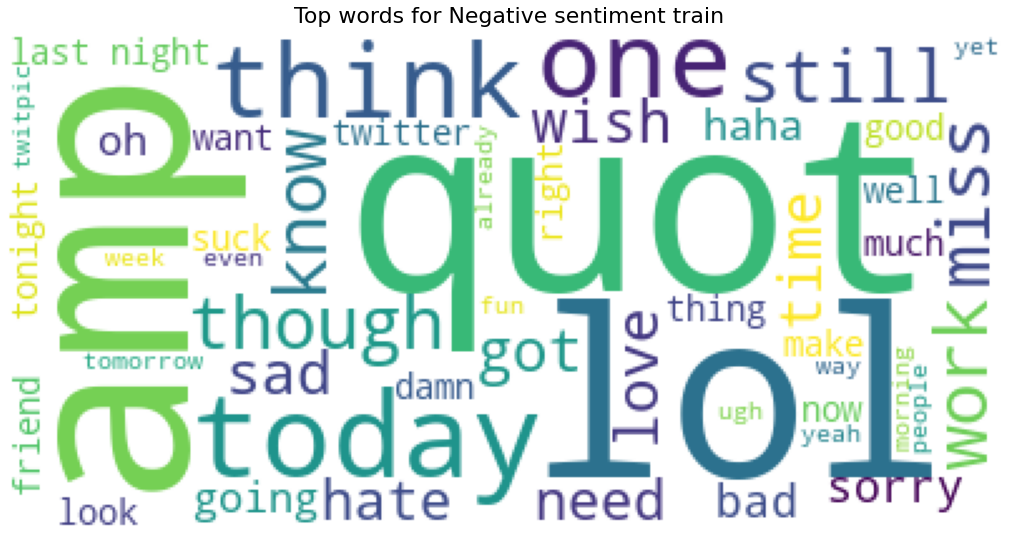

In [38]:
#@title
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_train.loc[df_train['sentiment'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative sentiment train', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

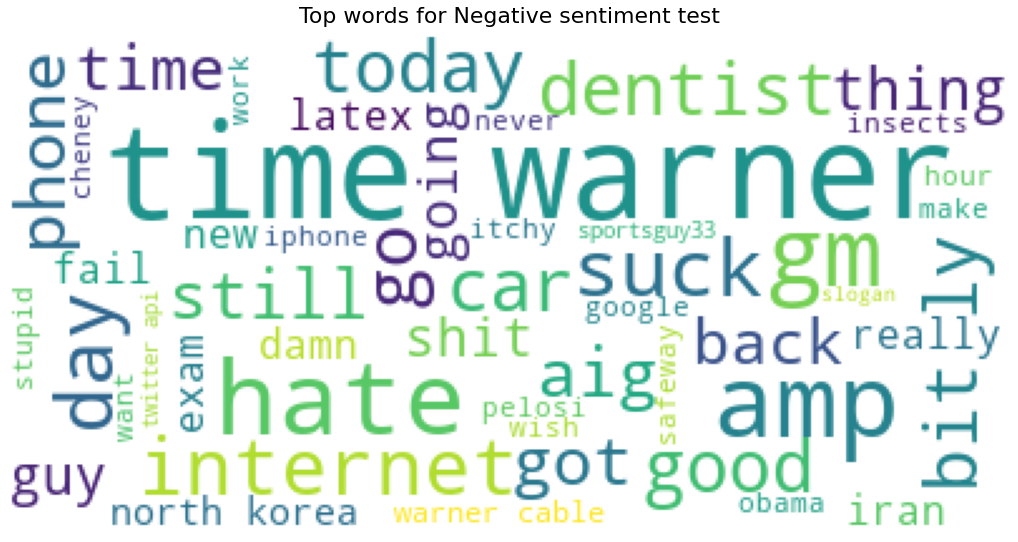

In [39]:
#@title
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_test.loc[df_test['sentiment'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative sentiment test', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

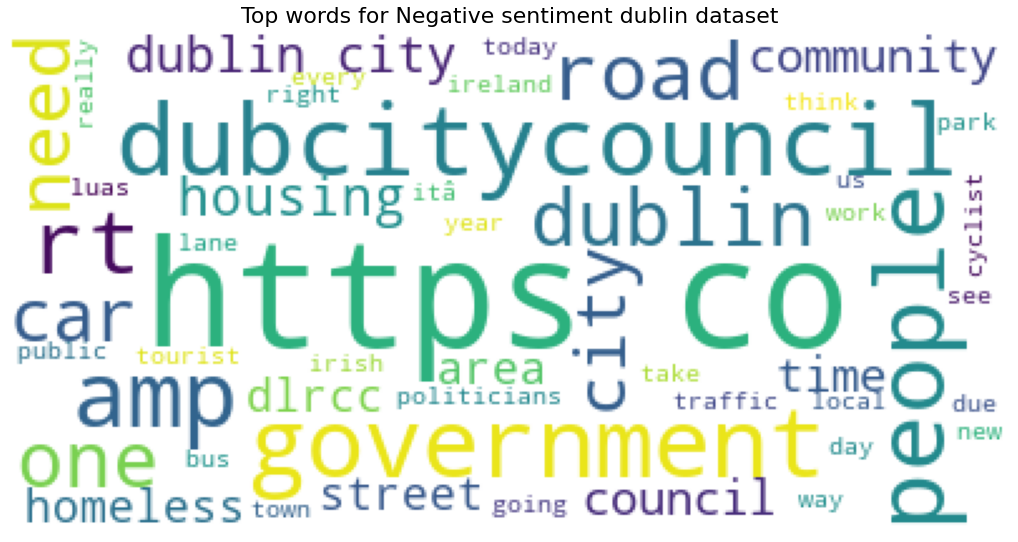

In [40]:
#@title
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_dublin.loc[df_dublin['sentiment'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative sentiment dublin dataset', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# Baseline model coeficients

In [41]:
#@title
data = {'word': word_vectorizer.get_feature_names(), 'coef': lr.coef_[0]}

df_coef = pd.DataFrame(data=data)

In [42]:
#@title
df_coef.sort_values('coef', ascending = False, inplace = True)

### Words with higher coefficients (correlated with positive sentiment prediction)

In [43]:
#@title
df_coef.head(10)

,word,coef
4204,t wait,5.920898
4817,wish luck,5.552003
4279,thank,4.405276
899,congratulations,4.106905
4770,welcome,4.061546
3924,smile,4.039673
4285,thanks,4.009752
3926,smiling,3.939212
541,blessed,3.661621
1444,feel free,3.640113


### Words with lower coefficients (correlated with negative sentiment prediction)

In [44]:
#@title
df_coef.tail(10)

,word,coef
238,air france,-5.401587
3452,r p,-5.538011
2841,miss,-5.562893
4595,unfortunately,-5.716574
1830,gutted,-5.797596
3320,poor,-5.811687
3197,passed away,-6.116379
3699,sadly,-6.270034
656,bummed,-6.305496
3692,sad,-9.677375


# SHAP values of baseline model with test dataset 

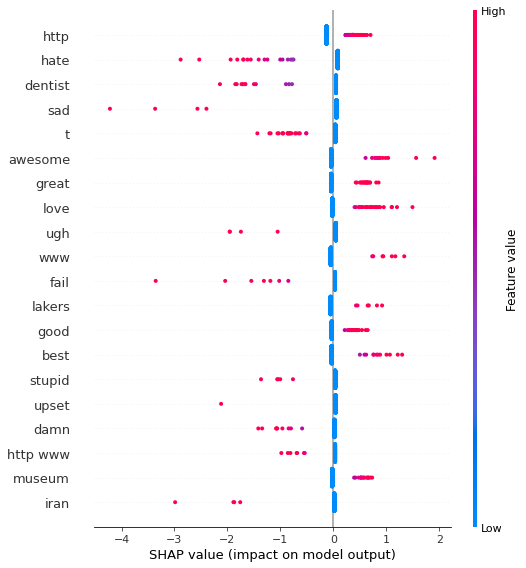

In [50]:
#@title
explainer = shap.LinearExplainer(lr,
                                 test_features)
shap_values = explainer.shap_values(test_features)
X_test_array = test_features.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with dublin dataset 

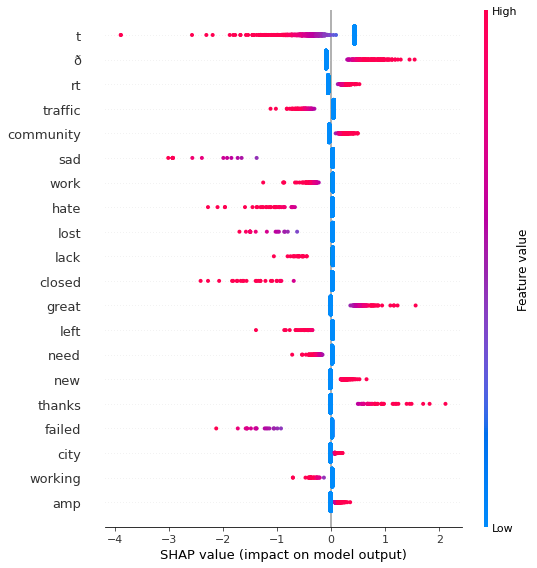

In [46]:
#@title
explainer = shap.LinearExplainer(lr,
                                 dublin_features)
shap_values = explainer.shap_values(dublin_features)
X_test_array = dublin_features.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with test dataset only with correct predictions

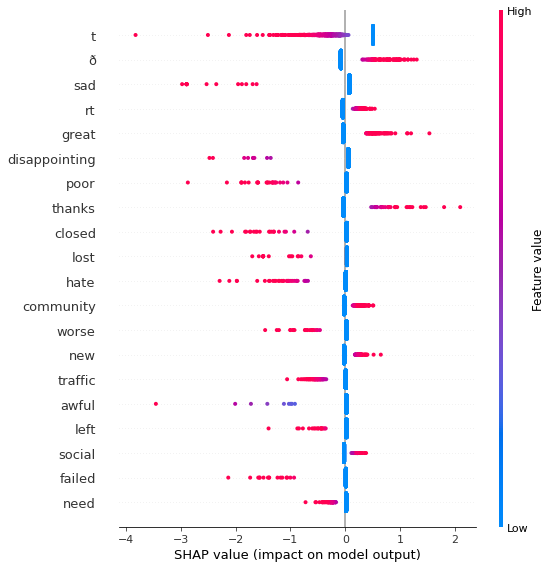

In [47]:
#@title
mask = df_dublin[df_dublin['sentiment'] == df_dublin['sentiment_pred_class']].index

explainer = shap.LinearExplainer(lr,
                                 dublin_features[mask])
shap_values = explainer.shap_values(dublin_features[mask])
X_test_array = dublin_features[mask].toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with test dataset only with wrong predictions

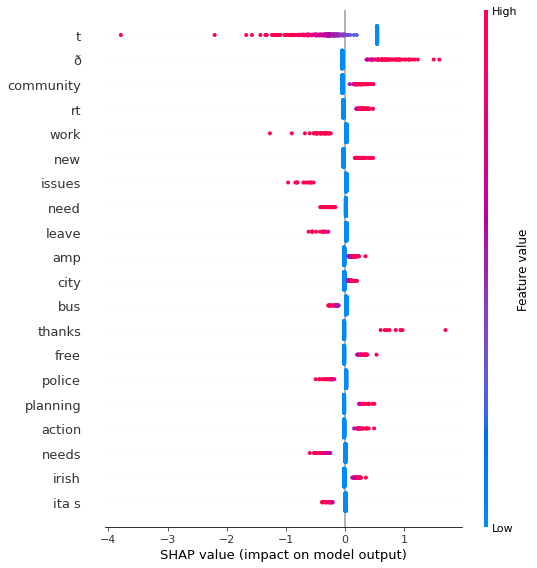

In [51]:
#@title
mask = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].index

explainer = shap.LinearExplainer(lr,
                                 dublin_features[mask])
shap_values = explainer.shap_values(dublin_features[mask])
X_test_array = dublin_features[mask].toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values for individual cases of wrong predictions

Tweet 1/10
Real sentiment: 1
Predicted sentiment: 0
Bringing shared #micromobility e-bike &amp; e-scooter solutions to bear on Dublinâs traffic congestion, will help our ranking enormously

Looking forward to @Dub_Bleeper @MobyMove new schemes + arrival of shared scooter operators in time also @smartdublin @jcudden @LordMayorDublin https://t.co/Adw9XsJOTQ


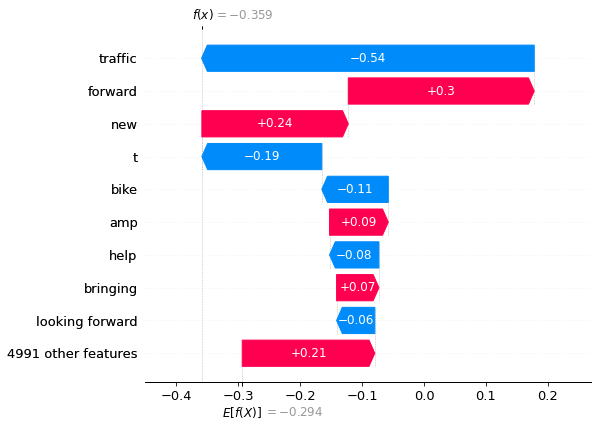

Tweet 2/10
Real sentiment: 1
Predicted sentiment: 0
@ShayBrennan @dlrcc @DublinVelo2019 @DublinCommuters @dlrcycling @IBIKEDublin @Cyclistie @dlbcycles @Greenaer We might be able to help with the clothing issueð


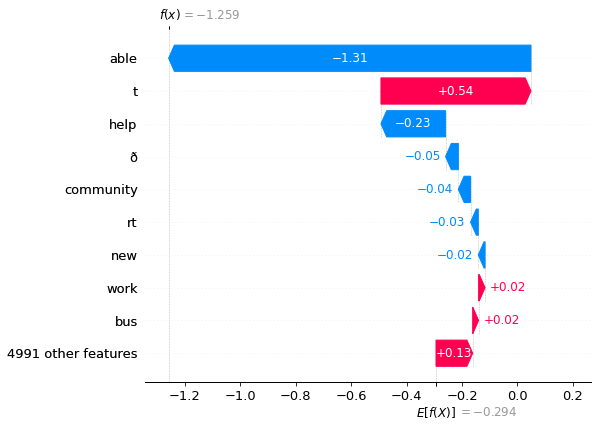

Tweet 3/10
Real sentiment: 1
Predicted sentiment: 0
does anyone @DubCham remember Clontarf, Blackrock or"Rainbow Rapids",aka Dun Laoghaire Baths not to mention the constant sewage overflows into Dublin Bay&amp; boil water notices. How much will the insurance cost?
https://t.co/4dzq7nikqk
https://t.co/xKbyLjJATC
https://t.co/eWnc2V47YH https://t.co/Prshzhd9OL


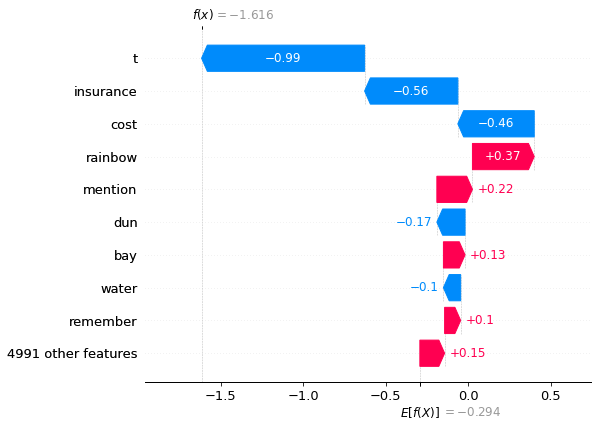

Tweet 4/10
Real sentiment: 1
Predicted sentiment: 0
In the latest episode of The Explainer, we examine plans for a white-water rafting facility in Dublin city centre https://t.co/NUxgq2FmT9


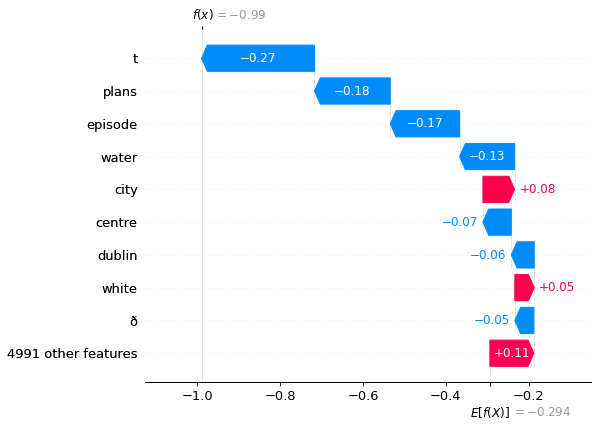

Tweet 5/10
Real sentiment: 1
Predicted sentiment: 0
Great article by Colm McCarthy on the NIMBYism going on around #busconnects
If we want a liveable city we need BusConnects with it's cycleways; trees, gardens and parking partially reduced is a price worth paying #LE19 candidates take note. https://t.co/ZJSfgqecX9


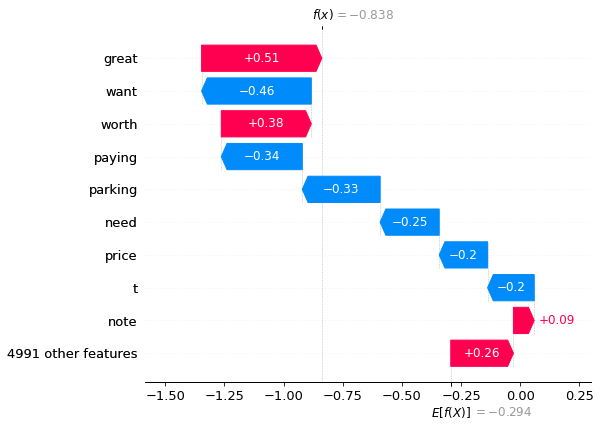

Tweet 6/10
Real sentiment: 1
Predicted sentiment: 0
@SoniaMcEntee @PatJCurran @greenparty_ie He wasnât misrepresented at all. Watch it back. It is what he said. The reality is that @greenparty_ie is a south Dublin party. In many parts of the country there is next to no reliable  public transport.


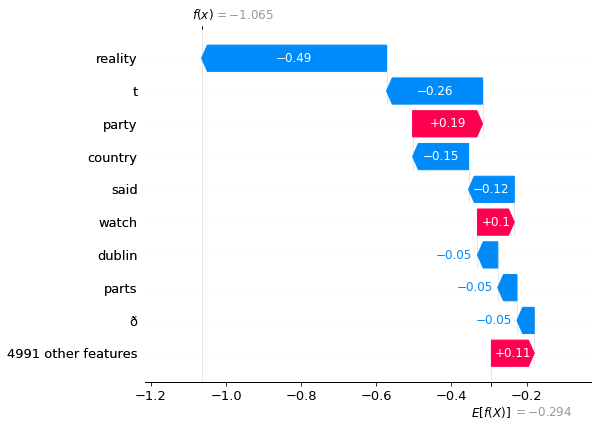

Tweet 7/10
Real sentiment: 1
Predicted sentiment: 0
@pauldclynam @ChrisILbondo @LeoVaradkar This isnât about one pub closing, even though the Shaw is more than just a pub, itâs about the systematic destruction of every single artistic space in the city and itâs descent into a soulless boring kip filled with hotels and donut shops


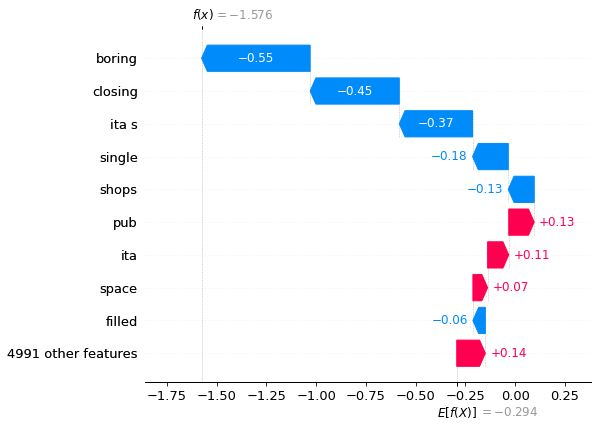

Tweet 8/10
Real sentiment: 1
Predicted sentiment: 0
@IrishRail Is that primary school education you are talking about ?
If it is , then put me down for a job . I could blow a whistle on the platform  or put coal on the fire , make soggy sandwiches and cold tea , as good as anyone


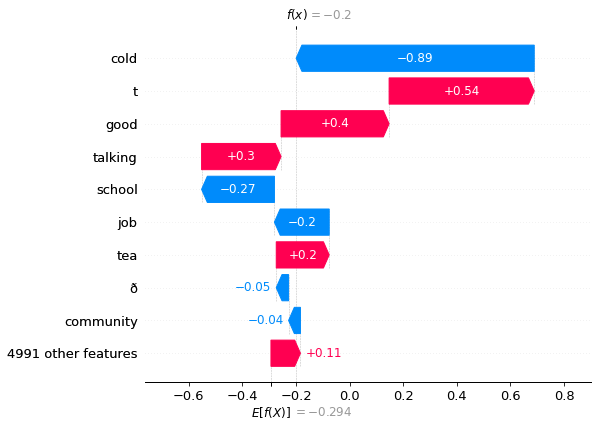

Tweet 9/10
Real sentiment: 1
Predicted sentiment: 0
@DubFireBrigade Delighted to see no emergencies in Cabra (this far). Community has spent years trying to eliminate bonfires and working with @DubCityCouncil we have tried to replace bonfires with organised celebrations in Finbarrs GAA. Cabrach abÃº. https://t.co/sURwYCt6ir


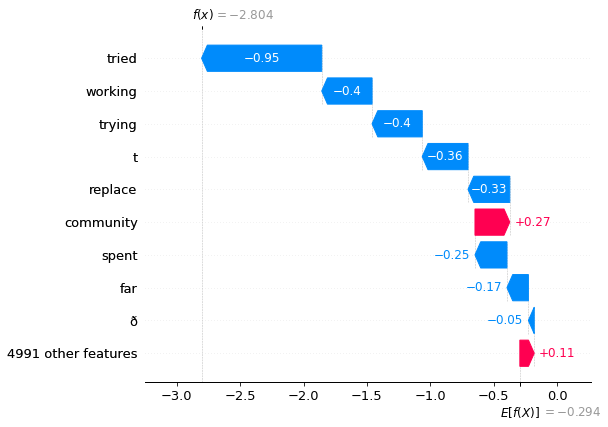

Tweet 10/10
Real sentiment: 1
Predicted sentiment: 0
An indication of likely scale of the latest Schools strike for climate action in Ireland today....plus latest news in advance of protests https://t.co/vq77j5APw2 https://t.co/9BWOg7davV


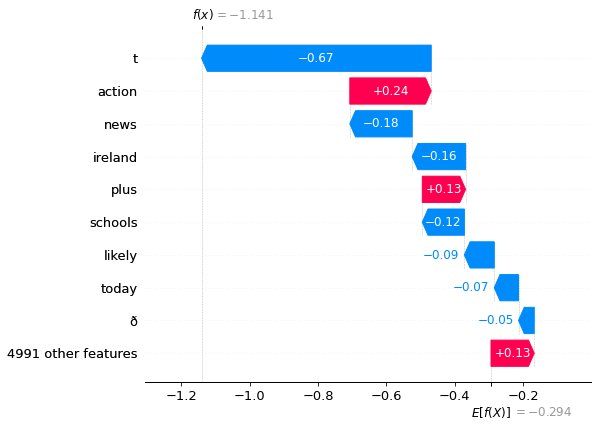

In [49]:
#@title
for i in range(N_TWEET_PRINT):
    y_true_n = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'sentiment']
    y_pred_n = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'sentiment_pred_class']
    print(f"Tweet {i+1}/{N_TWEET_PRINT}")
    print(f"Real sentiment: {y_true_n}")
    print(f"Predicted sentiment: {y_pred_n}")
    print(df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'text'])
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[i], feature_names=word_vectorizer.get_feature_names())

In [49]:
#@title


In [49]:
#@title
